<a href="https://colab.research.google.com/github/ashesh-0/PdfFromImages/blob/master/PagePixelSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Code inspiration taken from https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

*   Data created using https://labelbox.com



# Fetching Images and their masks

In [1]:
!pip install -q albumentations==0.3.0
!pip install -q segmentation-models

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 21.8MB 379kB/s 
     |████████████████████████████████| 634kB 51.2MB/s 


In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

In [4]:
from google.colab import drive    
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
BATCH_SIZE = 8

In [0]:
import json
import numpy
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

ORIG_SIZE = (1536, 2048)
TRAIN_JSON_FPATH = 'train.json'
VAL_JSON_FPATH = 'val.json'


def plot(img, mask):
    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    imshow(img, ax=ax[0])
    imshow(img * (mask.reshape(mask.shape[0], mask.shape[1], 1)), ax=ax[1])


def load_json(fpath):
    with open(fpath, 'r') as f:
        lines = f.read().strip().splitlines()
    assert len(lines) == 1
    output = json.loads(lines[0])
    return [p for p in output if p['External ID'] != 'title.jpg']


def get_mask(row):
    """
    Returns the mask {0,1} array for the image represented by row.
    """
    polygon = row['Label']['page'][0]['geometry']
    polygon = [(r['x'], r['y']) for r in polygon]
    mask = Image.new('L', (ORIG_SIZE[1], ORIG_SIZE[0]), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return numpy.array(mask)


def get_img(row, directory):
    """
    Args:
        row: one row of LabelMe generated json
        directory: directory where all images are stored

    It returns the image array
    """
    return imread(os.path.join(directory, row['External ID']))


def train_validation_separation(json_fpath, val_fraction=0.2):
    json_data = load_json(json_fpath)
    train_data, validation_data = train_test_split(json_data, test_size=val_fraction)
    with open(TRAIN_JSON_FPATH, 'w') as f:
        f.write(json.dumps(train_data))
    with open(VAL_JSON_FPATH, 'w') as f:
        f.write(json.dumps(validation_data))


In [0]:
DATA_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/'
raw_data = load_json(os.path.join(DATA_DIR,'book_segmentation.json'))


In [0]:
train_validation_separation(os.path.join(DATA_DIR,'book_segmentation.json'))

In [9]:
ls

gdrive/  sample_data/  train.json  val.json


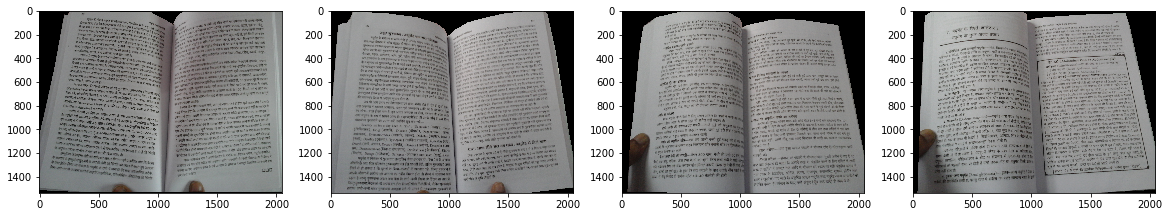

In [10]:
_,ax=plt.subplots(ncols=4,figsize=(20,5))
for idx, i in enumerate(np.random.choice(len(raw_data),size=4,replace=False)):
  img = get_img(raw_data[i],os.path.join(DATA_DIR,'data'))
  mask =get_mask(raw_data[i])
  ax[idx].imshow(img*(mask).reshape((mask.shape[0],mask.shape[1],1)))

## Data Preparation for model training

In [11]:
import keras
# from data_utils import get_img, get_mask, load_json
import numpy as np
import albumentations as A

IMG_SIZE = (320, 320)
MIN_SCALE = 0.5

# def crop_from_edges(img, mask, **kwargs):
#     H, W = img.shape[:2]

#     r = min(MIN_SCALE, np.random.rand())
#     # final image shape
#     h = int(H * r)
#     w = int(W * r)

#     edge = int(4 * np.random.rand())
#     if edge == 0:
#         # top edge
#         return (img[:h, :w], mask[:h, :w]) if np.random.rand() > 0.5 else (img[:h, -w:], mask[:h, -w:])
#     elif edge == 1:
#         # right
#         return (img[:h, -w:], mask[:h, -w:]) if np.random.rand() > 0.5 else (img[-h:, -w:], mask[-h:, -w:])
#     elif edge == 2:
#         # bottom
#         return (img[-h:, :w], mask[-h:, :w]) if np.random.rand() > 0.5 else (img[-h:, -w:], mask[-h:, -w:])
#     else:
#         # left
#         return (img[:h, :w], mask[:h, :w]) if np.random.rand() > 0.5 else (img[-h:, :w], mask[-h:, :w])


def get_training_augmentation():
    # Taken and modified from
    #  https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # A.RandomCrop(height=320, width=320, always_apply=True),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # Take patches from sides so that more edges are seen.
        # A.Lambda(mask=crop_from_edges),
        A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    return A.Compose([A.Resize(IMG_SIZE[0], IMG_SIZE[1])], p=1)


class DataLoader:
    def __init__(self, json_path: str, img_directory: str, augmentation=None, batch_size: int = 8):
        """
        Args:
            json_path: path of the json file generated by Labelbox website.
            img_directory: directory where images are present
        """
        self.json = load_json(json_path)
        self.imgs = np.stack([get_img(row, img_directory) for row in self.json], axis=0)
        self.masks = np.stack([get_mask(row) for row in self.json], axis=0)
        self.masks = self.masks.reshape((self.masks.shape[0], self.masks.shape[1], self.masks.shape[2], 1))
        self.aug = augmentation

    def __getitem__(self, i):
        if self.aug is not None:
            sample = self.aug(image=self.imgs[i], mask=self.masks[i])
            return (sample['image'], sample['mask'])

        return (self.imgs[i].copy(), self.masks[i].copy())

    def __len__(self):
        return len(self.imgs)


class DataGenerator(keras.utils.Sequence):
    def __init__(self, json_path: str, img_directory: str, augmentation=None, batch_size: int = 8):
        """
        Args:
            json_path: path of the json file generated by Labelbox website.
            img_directory: directory where images are present
        """
        self.batch_size = batch_size
        self.dataset = DataLoader(json_path, img_directory, augmentation=augmentation, batch_size=batch_size)
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    # def on_epoch_end(self):
    #     """Callback function to shuffle indexes each epoch"""
    #     if self.shuffle:
    #         self.indexes = np.random.permutation(self.indexes)


Using TensorFlow backend.


In [0]:
# JSON_PATH = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/book_segmentation.json'
IMG_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/data'

aug = get_training_augmentation()
datagen = DataGenerator(TRAIN_JSON_FPATH,IMG_DIR,augmentation=aug,batch_size=BATCH_SIZE)

In [0]:
val_datagen = DataGenerator(VAL_JSON_FPATH,IMG_DIR,augmentation=get_validation_augmentation(),batch_size=BATCH_SIZE)

In [14]:
len(val_datagen)/len(datagen)

0.25

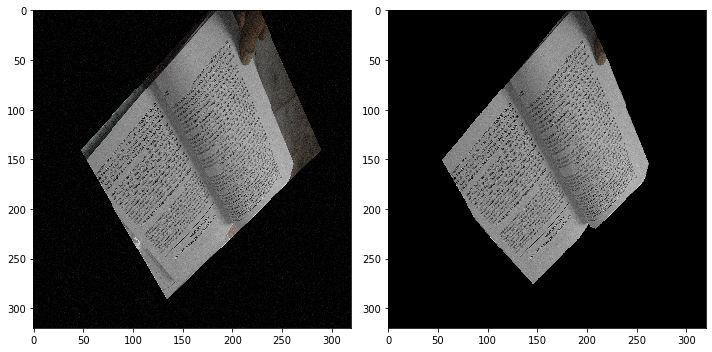

In [15]:
sample = datagen[10]
img,msk = sample[0][0],sample[1][0]
plot(img,msk)

## Model training

In [16]:
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'efficientnetb3'
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=1, activation=activation)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 1s 0us/step




In [19]:
optim = keras.optimizers.Adam(LR)
total_loss = sm.losses.binary_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
model_path = os.path.join(DATA_DIR,'best_model.h5')
if os.path.exists(model_path):
  model.load_weights(model_path)

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [22]:
history = model.fit_generator(
    datagen, 
    steps_per_epoch=len(datagen), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_datagen, 
    validation_steps=len(val_datagen),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
12/12 [==============================] - 55s 5s/step - loss: 0.0267 - iou_score: 0.9948 - f1-score: 0.9974 - val_loss: 0.0591 - val_iou_score: 0.9894 - val_f1-score: 0.9947
Epoch 2/30
12/12 [==============================] - 5s 410ms/step - loss: 0.0260 - iou_score: 0.9940 - f1-score: 0.9970 - val_loss: 0.0583 - val_iou_score: 0.9899 - val_f1-score: 0.9949
Epoch 3/30
12/12 [==============================] - 25s 2s/step - loss: 0.0281 - iou_score: 0.9938 - f1-score: 0.9969 - val_loss: 0.0554 - val_iou_score: 0.9902 - val_f1-score: 0.9951
Epoch 4/30
12/12 [==============================] - 25s 2s/step - loss: 0.0222 - iou_score: 0.9950 - f1-score: 0.9975 - val_loss: 0.0579 - val_iou_score: 0.9898 - val_f1-score: 0.9949
Epoch 5/30
12/12 [==============================] - 25s 2s/step - loss: 0.0219 - iou_score: 0.9957 - f1-score: 0.9978 - val_loss: 0.0558 - val_iou_score: 0.9898 - val

In [0]:
val_X = []
for elem in val_datagen:
  val_X.append(elem[0])
val_X = np.concatenate(val_X,axis=0)

## Visual evaluation on validation set.
**TODO**
1. One needs to fit a curve to get a sharp curve.
2. Fit a CRF to sharpen the edges

In [0]:
val_pred = model.predict(val_X)

In [35]:
val_X.shape

(24, 320, 320, 3)

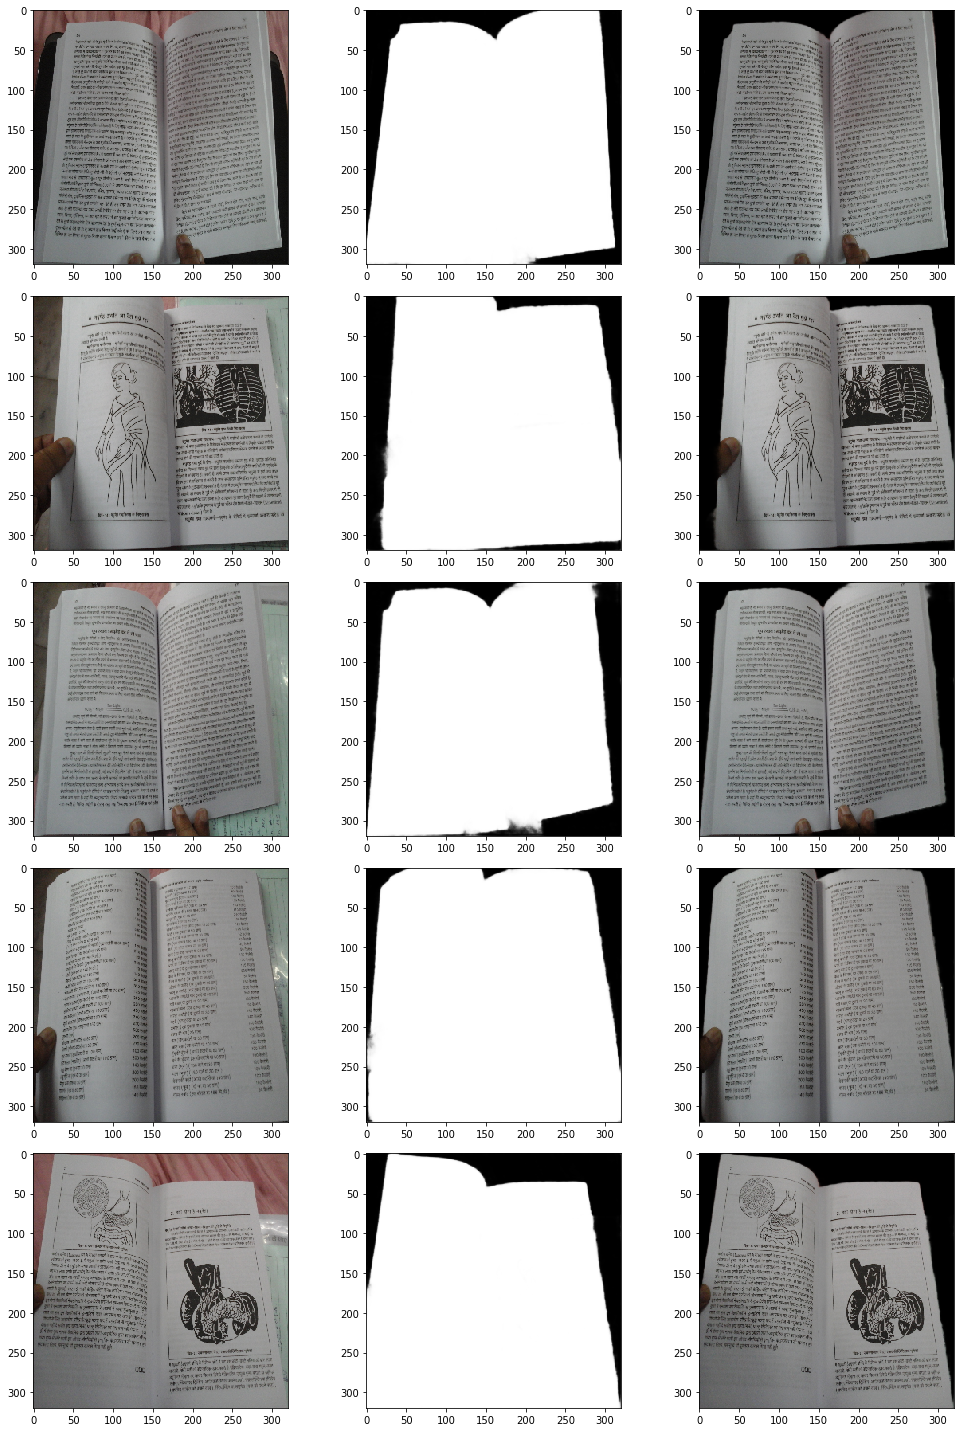

In [36]:
_,ax = plt.subplots(nrows = 5,ncols = 3, figsize=(15,20))

for idx, i in enumerate(np.random.choice(len(val_pred)-1,size=5,replace=False)):
  imshow(val_X[i],ax=ax[idx,0])
  imshow(val_pred[i,:,:,0],ax=ax[idx,1])
  imshow(val_X[i]*val_pred[i,:,:]/255,ax=ax[idx,2])

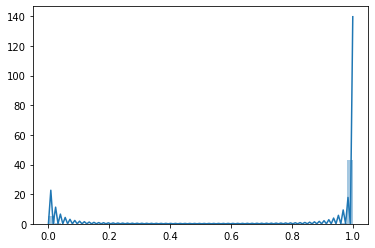

In [37]:
sns.distplot(val_pred.reshape((-1,)))